In [1]:
import os  
import pandas as pd
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats, signal, optimize

In [2]:
def LoadFileABF_CC(filename):
    abf = pyabf.ABF(filename)
    #abf.headerLaunch()

    abf.setSweep(sweepNumber=0, channel=0)
    t = abf.sweepX
    sr = abf.dataRate
    V = np.empty((0,abf.sweepPointCount))
    I = np.empty((0,abf.sweepPointCount))

    for sweep in range(abf.sweepCount):    
        abf.setSweep(sweepNumber=sweep, channel=0)
        V = np.vstack((V, abf.sweepY.reshape(1,-1)))
        abf.setSweep(sweepNumber=sweep, channel=1)
        I = np.vstack((I, abf.sweepY.reshape(1,-1)))

    return V, I, t, sr

In [3]:
def Analyse_IntrinsicProfile(V, I, t, sr, plotting=0):
    # Initialise output variables
    commandDuration = 0
    I_command = 0
    V_Ih = np.nan
    V_SS = np.nan
    AP_number = np.nan
    AP_firingFrequency = np.nan
    AP_threshold = np.nan
    AP_spikeHeight = np.nan
    AP_halfWidth = np.nan
    AP_fAHP = np.nan
    AP_adaptationIndexLast = np.nan 
    AP_adaptationIndexSecond = np.nan

    # Resting membrane potential
    RMP = np.median(V[0:int(0.05*sr)])    

    # Current command
    dI = np.insert(np.diff(I),0,0)
    I_peaks,_ = signal.find_peaks(dI,height=3)

    if np.shape(I_peaks)[0]:
        I_ON = np.argmax(dI)
        I_OFF = np.argmin(dI)
        if I_ON > I_OFF: # Negative current steps
            I_OFF = np.argmax(dI)
            I_ON = np.argmin(dI)

        commandDuration=t[I_OFF]-t[I_ON]
        I_command=np.round(np.mean(I[I_ON+int(0.1*sr):I_ON+int(0.2*sr)])-np.mean(I[I_ON-int(0.2*sr):I_ON-int(0.1*sr)]))

        if I_command < 0: #Hyperpolarizing current steps

            # Hyperpolarization-induced voltage sag
            V_Inst_idx = np.argmin(V[I_ON:I_OFF])+I_ON
            V_Inst = V[V_Inst_idx]
            V_SS = np.mean(V[I_OFF-int(0.05*sr):I_OFF])
            V_Ih = V_SS - V_Inst

        else: # Depolarising current steps

            #Firing frequency: number action potentials (APs)
            V_peaks, _ = signal.find_peaks(V[I_ON:I_OFF],height=-20,prominence=10)          
            AP_number = np.shape(V_peaks)[0]
            AP_firingFrequency = AP_number/commandDuration

            #Find firing frequency adaptation
            if np.shape(V_peaks)[0] >= 3:

                #Simon's method
                adaptationWindow = 0.1
                spikeN_i = np.count_nonzero((V_peaks) < adaptationWindow*sr)
                spikeN_f = np.count_nonzero(((V_peaks) > (commandDuration-adaptationWindow)*sr) & ((V_peaks) < commandDuration*sr))
                if spikeN_i != 0:
                    AP_adaptationIndexLast = (spikeN_i-spikeN_f)/spikeN_i*100

                # Scala et al., 2020 method: ratio between second inter-spike interval and first interspike interval
                AP_adaptationIndexSecond = (V_peaks[2]-V_peaks[1])/(V_peaks[1]-V_peaks[0])


            if np.shape(V_peaks)[0] in [1,2,3]:

                # Action potential features
                V_peaks = V_peaks + I_ON
                if np.shape(V_peaks)[0] in [2,3]:
                    end_idx = (V_peaks)[1]
                else:
                    end_idx = I_OFF   
                    
                AP_window = np.arange(V_peaks[0]-int(0.03*sr),end_idx)
                AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Spike(V[AP_window], t[AP_window], sr, int(0.03*sr), plotting)

    return [commandDuration, I_command, RMP, V_SS, V_Ih, AP_number, AP_firingFrequency, AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP, AP_adaptationIndexLast, AP_adaptationIndexSecond]

In [4]:
def Analyse_Spike(V, t, sr, spikeIdx, plotting=0):
    # AP threshold: first derivative method, 10mV/ms cut-off
    thresholdCutOff = 10 #mV/ms
    dV = np.insert(np.diff(V,n=1),0,0)
    dV_peaks, _ = signal.find_peaks(dV,height=1)
    dV=dV*(sr/10**3) # Convert to mv/ms
    Th_idx = np.argmin(abs(dV[:dV_peaks[0]]-thresholdCutOff))
    AP_threshold = V[Th_idx]

    #  AP height
    AP_peakHeight = V[spikeIdx]
    AP_spikeHeight = AP_peakHeight-AP_threshold

    # AP half-width
    AP_halfHeigth = AP_spikeHeight/2
    Half_Start = np.argmin(abs(V[Th_idx:spikeIdx]-(AP_peakHeight-AP_halfHeigth)))+Th_idx
    Half_End = np.argmin(abs(V[spikeIdx:]-(AP_peakHeight-AP_halfHeigth)))+spikeIdx
    AP_halfWidth = t[Half_End]-t[Half_Start]

    # Fast AHP (fAHP) amplitude
    fAHP_idx = np.argmin(V[spikeIdx:spikeIdx+int(0.007*sr)])+spikeIdx
    AP_fAHP = AP_threshold - V[fAHP_idx]

    #Plot AP and points of interest
    if plotting:
        plt.figure()
        plt.plot(t,V)
        plt.plot(t[spikeIdx],V[spikeIdx],'rx')
        plt.plot(t[Th_idx],V[Th_idx],'bx')
        plt.plot(t[Half_Start],V[Half_Start],'bx')
        plt.plot(t[Half_End],V[Half_End],'bx')
        plt.plot(t[fAHP_idx],V[fAHP_idx],'bx')              

    return(AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP)

In [5]:
def Analyse_Tau(V, I, t, sr, plotting=0):
    #Start-end current command
    dI = np.insert(np.diff(I),0,0)
    I_peaks,_ = signal.find_peaks(dI,height=5)
    assert np.shape(I_peaks)[0]
    I_OFF = np.argmax(dI)
    I_ON = np.argmin(dI)

    # Decay time constant
    def mono_exp(x, a, b):
        return a * np.exp(b * x)

    xfit = t[I_ON:I_OFF]
    yfit = V[I_ON:I_OFF]-np.mean(V[I_OFF-int(0.005*sr):I_OFF])
    popt,pcov = optimize.curve_fit(mono_exp, xfit, yfit, method = 'lm', maxfev = 15000, ftol = 10**-10)
    Tau = 1/(-popt[1])     
    
    #Plot tau fitting
    if plotting:
        interpolX=t[I_ON-int(0.02*sr):I_OFF]
        plt.figure()
        plt.plot(xfit, yfit, 'k', label="Data")
        plt.plot(interpolX, mono_exp(interpolX, *popt), 'r-', label="Fitted Curve")            
        plt.legend()
        plt.show()

    return Tau

In [6]:
def Analyse_Neuron(neuron, plotting=0):
    # Initialise dataframe for single cell data 
    cols=['CurrentDuration','CurrentAmplitude','RMP','VoltageSteadyState','VoltageSag','ActionPotentialNumber','FiringFrequency','SpikeThreshold','SpikeHeight','SpikeHalfWidth','SpikeAHP','AdaptationIndexLast','AdaptationIndexSecond']
    neuronResults=pd.DataFrame(columns=cols)

    #### Obtain data
    for i, filename in enumerate(neuron.filename):
        if i == 0:
            neuron.reset_index(inplace=True, drop=True)

        if neuron.Experiment[i]=='IntrinsicProfile':  
            print("Analysing"+filename)
            V, I, t, sr = LoadFileABF_CC(neuron.foldername[i]+"\\"+neuron.CellID[i]+"\\"+filename)

            for sweep in range(V.shape[0]):
                neuronResults.loc[len(neuronResults), :] = Analyse_IntrinsicProfile(V[sweep,:], I[sweep,:], t, sr, plotting)
    
    #### Save all data
    neuronResults[cols] = neuronResults[cols].astype(float)
    outputFolder = os.path.join(neuron.foldername[0],neuron.CellID[0],'IntrinsicProfile')
    if not os.path.isdir(outputFolder):
        os.mkdir(outputFolder)
    neuronResults.to_csv(os.path.join(outputFolder,neuron.CellID[0]+'.csv'), index=False)
    
    ##### Calculate features
#     # Select only multiples of 10 pA current steps
#     def myround(x, base=5):
#         return  np.round(x/base)*base
#     neuronResults.CurrentAmplitude = myround(neuronResults.CurrentAmplitude.to_numpy(dtype=float), 5)
#     neuronResults = neuronResults[neuronResults.CurrentAmplitude%10==0]
    
    # Tau        
    hyperpolarisingStepsIdx = np.array(neuronResults[(neuronResults.CurrentAmplitude >= -200)&(neuronResults.CurrentAmplitude < 0)].index, dtype=int)
    medianV = np.median(V[hyperpolarisingStepsIdx,:],0)
    Tau = Analyse_Tau(medianV, I[0,:], t, sr, plotting)
    
    # Firing
    MaxFiringFrequency = neuronResults.FiringFrequency.max()
    AdaptationIndex = neuronResults[neuronResults.ActionPotentialNumber >= 3].AdaptationIndexSecond[:5].median()

    # RMP and Rin
    xH = np.array(neuronResults[(neuronResults.CurrentAmplitude >= -200)&(neuronResults.CurrentAmplitude < 0)].CurrentAmplitude, dtype=float)
    yH = np.array(neuronResults[(neuronResults.CurrentAmplitude >= -200)&(neuronResults.CurrentAmplitude < 0)].VoltageSteadyState, dtype=float)

    slope, intercept = np.polyfit(xH, yH, 1)
    xHfit = np.arange(-150, 50, 10)
    yHfit = slope*xHfit + intercept
    
    Rin = slope*1000 # MOhm
    RMP = intercept # mV
            
    # Rheobase
    xD = np.array(neuronResults[neuronResults.ActionPotentialNumber > 0].CurrentAmplitude[0:5], dtype=float)
    yD = np.array(neuronResults[neuronResults.ActionPotentialNumber > 0].FiringFrequency[0:5], dtype=float)

    slope, intercept = np.polyfit(xD, yD, 1)
    xDfit = np.arange(10, max(xD), 10)
    yDfit = slope*xDfit + intercept
    
    Rheobase = -intercept/slope #pA            
            
    # Voltage sag
    VoltageSag = neuronResults.VoltageSag[0]

    # Spike features
    AP_Threshold = neuronResults[~neuronResults.SpikeThreshold.isnull()].SpikeThreshold.iloc[0]
    AP_Height = neuronResults[~neuronResults.SpikeThreshold.isnull()].SpikeHeight.iloc[0]
    AP_HalfWidth = neuronResults[~neuronResults.SpikeThreshold.isnull()].SpikeHalfWidth.iloc[0]
    AP_AHP = neuronResults[~neuronResults.SpikeThreshold.isnull()].SpikeAHP.iloc[0]               
    
    #### Make figure
    singleSpikeIdx = neuronResults[neuronResults.ActionPotentialNumber>0].ActionPotentialNumber.idxmin()
    maxSpikeIdx = neuronResults.FiringFrequency.idxmax()
    sagIdx = (neuronResults.VoltageSteadyState+100).idxmin()

    fig = plt.figure(figsize=[20, 20])
    gs = gridspec.GridSpec(7, 2)
    plt.suptitle(neuron.CellID[0] + ' - ' + neuron.CellTarget[0]+'-'+neuron.CellType[0], fontsize=30)
    
    ax1 = plt.subplot(gs[0:3, 0])
    ax1.plot(t,V[maxSpikeIdx,:],'k')
    ax1.set_xlim((1, 1.8))
    ax1.set_ylim((-110, 30))
    plt.axis('off')

    ax2 = plt.subplot(gs[3:6, 0])
    ax2.plot(t,V[singleSpikeIdx,:],'k')
    ax2.plot(t,V[sagIdx,:],'k')
    ax2.plot((1.6, 1.8), (0, 0),'k', linewidth=3)
    ax2.plot((1.6, 1.6), (0, 30),'k', linewidth=3)
    plt.text(1.61, 13, '30 mV', fontsize=20)
    plt.text(1.64, -8, '200 ms', fontsize=20)

    ax2.set_xlim((1, 1.8))
    ax2.set_ylim((-110, 30))
    plt.axis('off')

    ax3 = plt.subplot(gs[6, 0])
    ax3.plot(t, I[singleSpikeIdx,:],'k')
    ax3.plot(t, I[sagIdx,:],'k')
    ax3.plot(t, I[maxSpikeIdx,:],'k')
    ax3.set_xlim((1, 1.7))
    plt.axis('off')

    ax4 = plt.subplot(gs[0:4, 1])
    ax4.plot(neuronResults[neuronResults.CurrentAmplitude>=0].CurrentAmplitude, neuronResults[neuronResults.CurrentAmplitude>=0].FiringFrequency, 'ko')
    ax4.set_xlabel('Current (pA)', fontsize=20)
    ax4.set_ylim((0, neuronResults.FiringFrequency.max()+5))
    ax4.set_ylabel('Firing Frequency (Hz)', fontsize=20)
    ax4.tick_params(axis='both', which='major', labelsize=20)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_linewidth(3)
    ax4.spines['bottom'].set_linewidth(3)
    ax4.xaxis.set_tick_params(width=3, length=10)
    ax4.yaxis.set_tick_params(width=3, length=10)
    
    ax5 = plt.subplot(gs[4:,1])
    ax5.plot(xH, yH, 'ro')
    ax5.plot(xHfit, yHfit, 'k--')
    ax5.plot([0, 0], [-500, 500], 'k', linewidth=0.5)
    ax5.set_ylabel('Steady-state Vm (mV)', fontsize=20, color='r')
    ax5.set_xlabel('Current (pA)', fontsize=20)
    ax5.spines['left'].set_linewidth(3)
    ax5.spines['bottom'].set_linewidth(3)
    ax5.spines['top'].set_visible(False)
    ax5.xaxis.set_tick_params(width=3, length=10)
    ax5.yaxis.set_tick_params(width=3, length=10)
    ax5.tick_params(axis='both', which='major', labelsize=20)
    ax5.tick_params(axis='y', labelcolor='r')
    ax5.set_ylim((yH.min(), yH.max()+10))
    
    ax6 = ax5.twinx()  # instantiate a second axes that shares the same x-axis
    ax6.plot(xD, yD, 'bo')
    ax6.plot(xDfit, yDfit, 'k--')
    ax6.plot([-500, 500], [0, 0], 'k', linewidth=0.5)
    ax6.set_ylabel('Firing Frequency (Hz)', fontsize=20, color='b')
    ax6.spines['right'].set_linewidth(3)
    ax6.spines['top'].set_visible(False)
    ax6.xaxis.set_tick_params(width=3, length=10)
    ax6.yaxis.set_tick_params(width=3, length=10)
    ax6.tick_params(axis='both', which='major', labelsize=20)
    ax6.tick_params(axis='y', labelcolor='b')
    ax6.set_xlim((-100, xD.max()+5))
    ax6.set_ylim((-1, yD.max()+2))
    
    plt.text(-90,yD.max()-1,'RMP='+str(RMP.round())+' mV\nRin='+str(Rin.round())+' MOhm\nRheobase='+str(Rheobase.round())+' pA',fontsize = 20)
    gs.update(hspace = 0.5, wspace =0.2)

    plt.savefig(os.path.join(outputFolder,neuron.CellID[0]+'.pdf'), format='pdf', transparent=True)
    plt.savefig(os.path.join(outputFolder,neuron.CellID[0]+'.tif'), format='tif', transparent=True)
#     plt.close()
    
    #### Make output
    results = [neuron.CellID[0], neuron.CellTarget[0], neuron.CellType[0], RMP, Rin, Tau, Rheobase, AP_Threshold, AP_Height, AP_HalfWidth, AP_AHP, MaxFiringFrequency, AdaptationIndex, VoltageSag]

    return results

SA83.1
Analysing20623001.abf
SA83.2
Analysing20623006.abf
SA83.3
Analysing20623011.abf
SA83.4
Analysing20623018.abf
SA84.1
Analysing20623022.abf
SA85.1
Analysing20625018.abf
SA85.2
Analysing20625026.abf
SA85.3
Analysing20625031.abf
SA86.1
Analysing20625002.abf
SA86.2
Analysing20625010.abf


,Cell_ID,CellTarget,CellType,RMP,Rin,Tau,Rheobase,AP_Threshold,AP_Height,AP_HalfWidth,AP_AHP,MaxFiringFrequency,AdaptationIndex,VoltageSag
0,SA83.1,LHX6,PV,-62.1544,215.802,0.0513214,61.6667,-37.6587,56.2744,0.00165,18.0054,56,1.28637,1.2919
1,SA83.2,LHX6,PV,-59.8475,252.84,0.0404729,82,-32.4097,52.1851,0.0016,20.3552,48,1.08622,1.67953
2,SA83.3,LHX6,SST,-60.0922,391.332,0.0628355,31.6667,-39.5508,57.3425,0.002,6.28662,42,1.1439,2.70642
3,SA83.4,LHX6,PV,-56.8403,254.321,0.0172967,41.6667,-30.0293,48.6755,0.00155,19.8975,58,1.17475,0.465363
4,SA84.1,SSTCre,SST,-55.018,253.075,0.020352,72.6667,-31.0364,55.5115,0.00215,8.11768,16,1.79167,0.166199
5,SA85.1,SSTCre,SST,-59.6578,126.792,0.00997045,23.9412,-48.1873,60.6689,0.00155,9.39941,34,2.92169,0.88858
6,SA85.2,SSTCre,SST,-60.647,276.688,0.0331138,14.5769,-41.1987,69.2749,0.00155,7.32422,40,1.9008,4.81232
7,SA85.3,SSTCre,SST,-63.3627,215.936,0.0413847,48.5,-41.8091,53.772,0.00145,7.72095,54,1.08986,0.373657
8,SA86.1,SSTCre,SST,-55.3141,360.565,0.0771359,22.8913,-38.6963,59.6313,0.00135,9.33838,32,1.05165,0.362976
9,SA86.2,SSTCre,SST,-67.3829,170.484,0.0177308,67.6667,-43.7012,54.2603,0.0015,6.89697,20,1.73174,0.717255


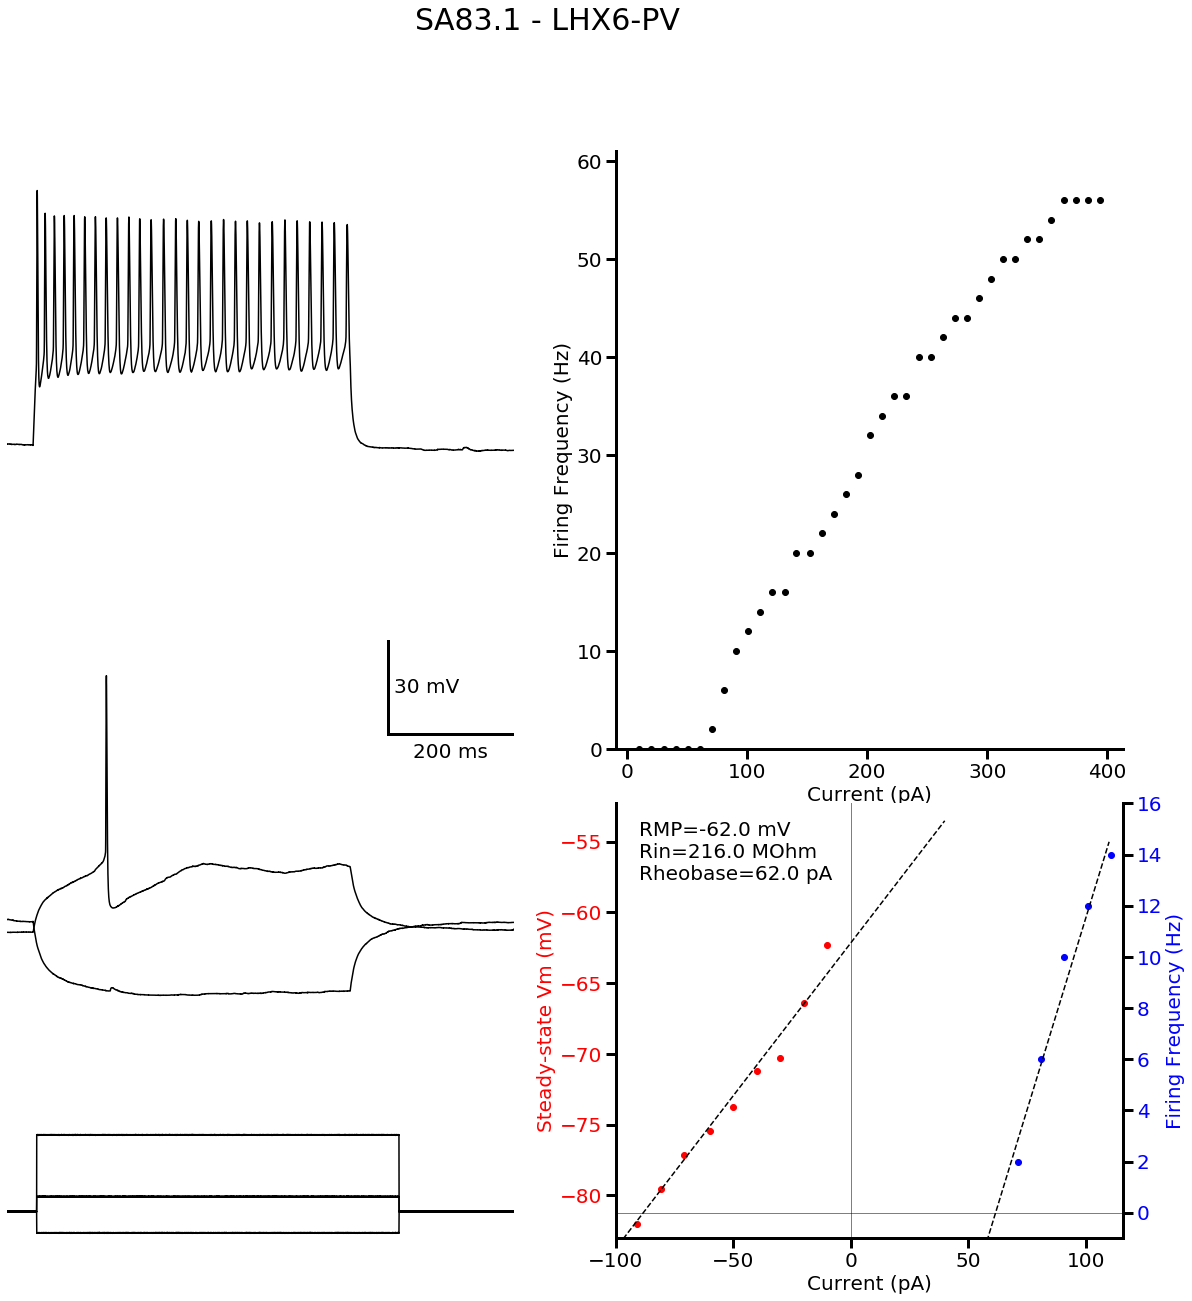

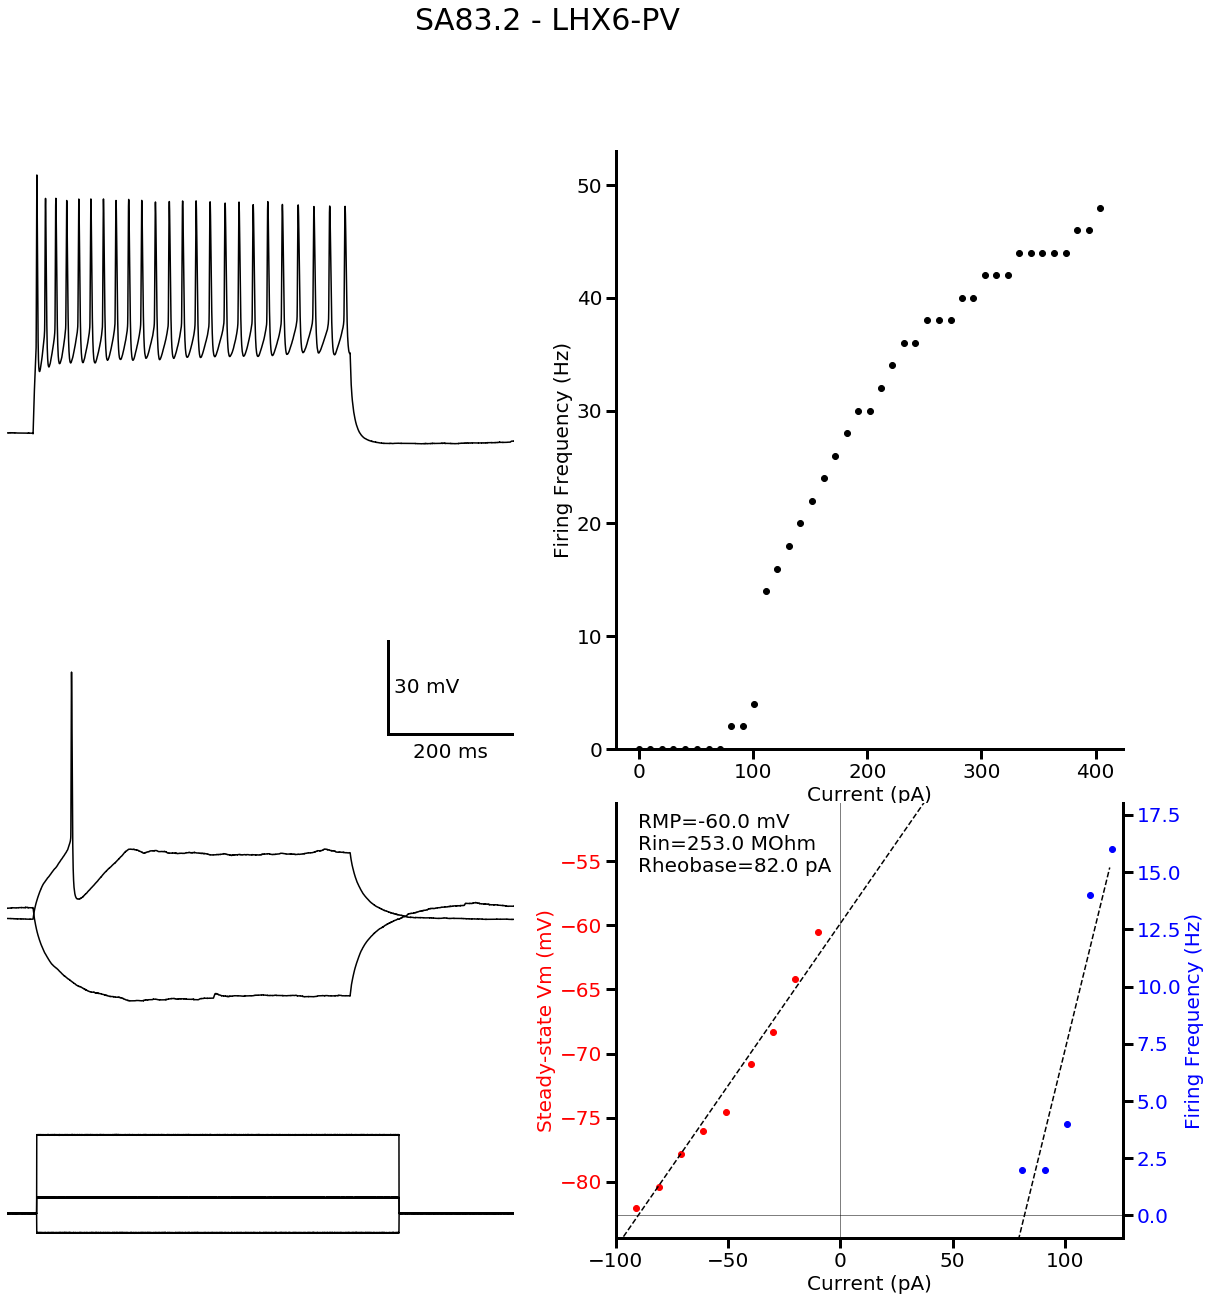

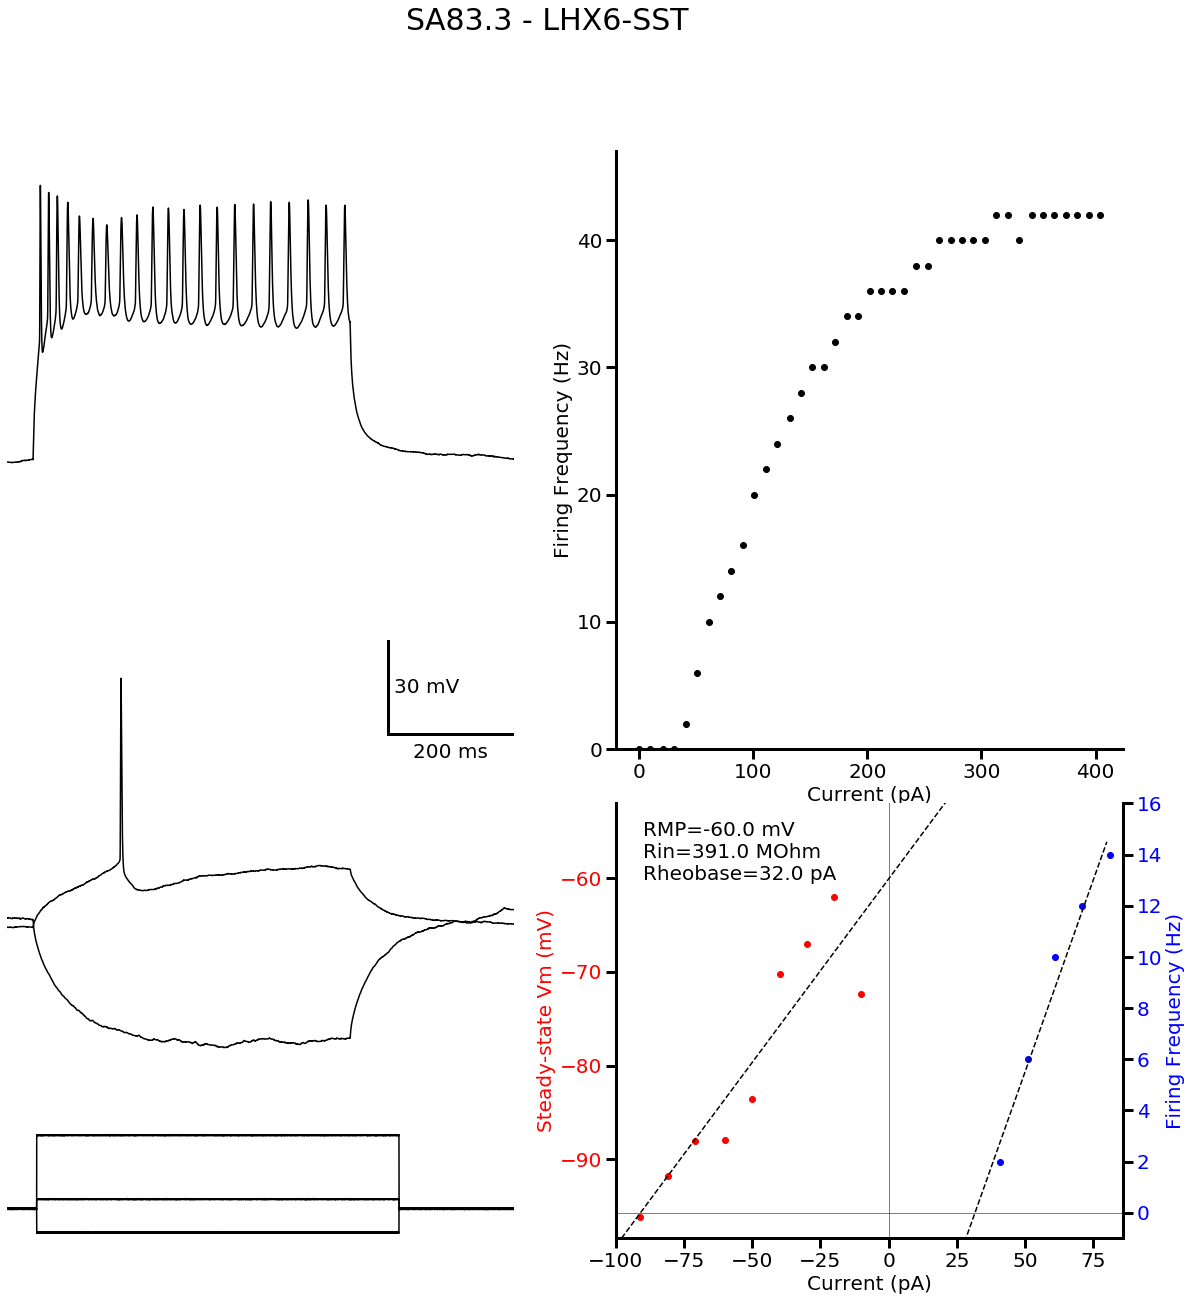

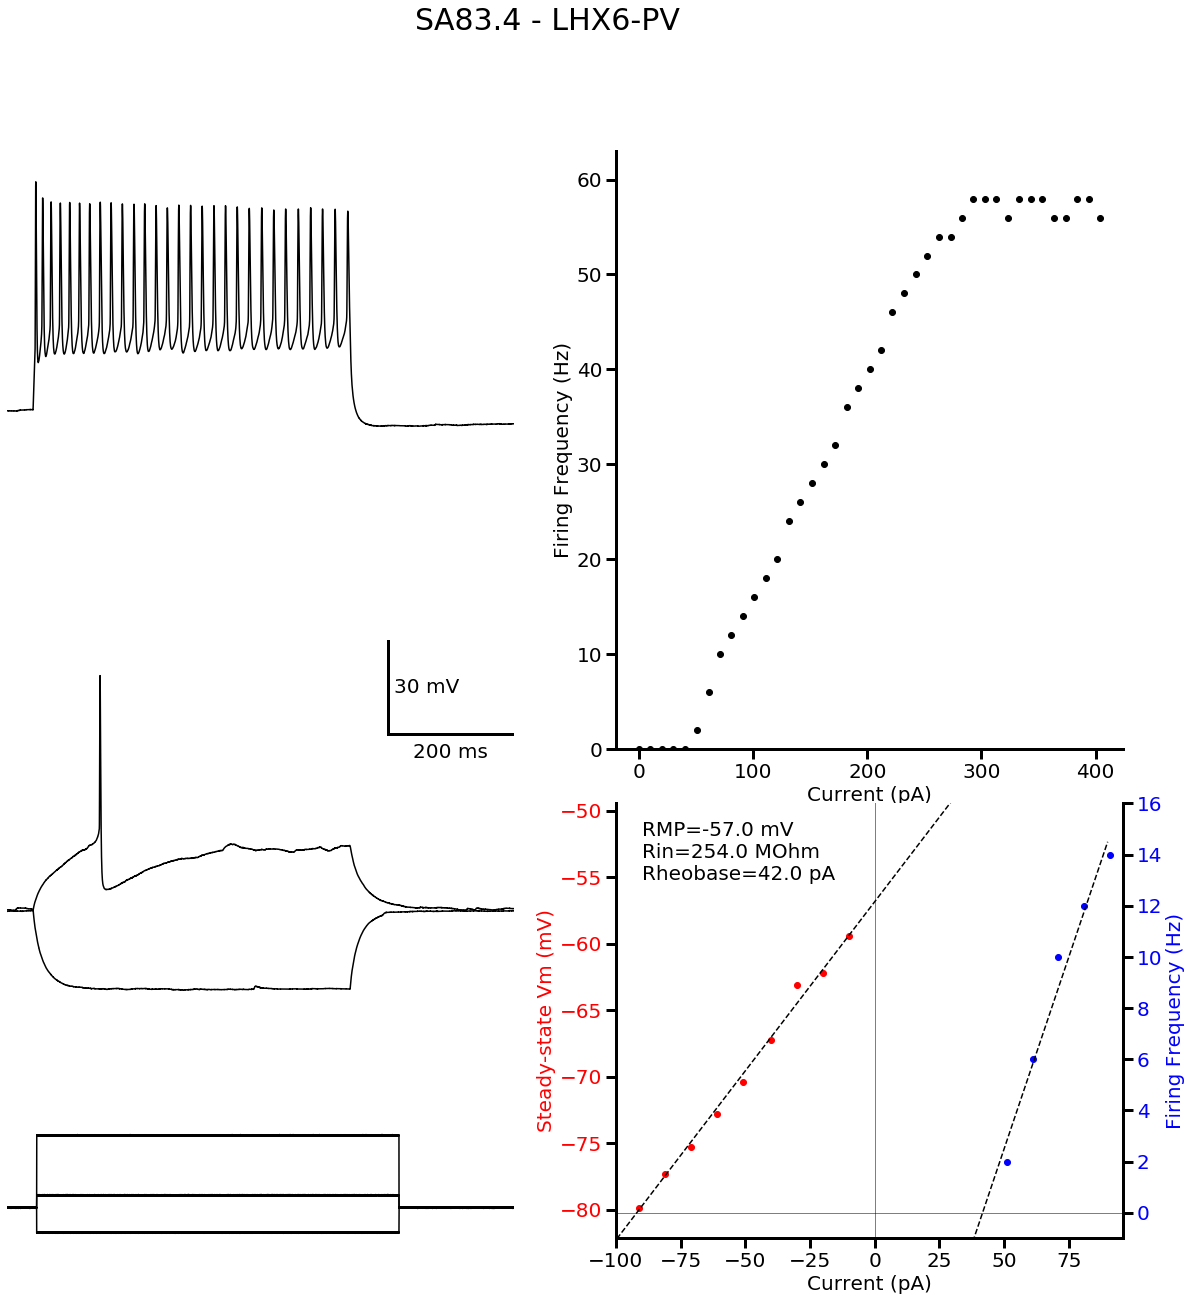

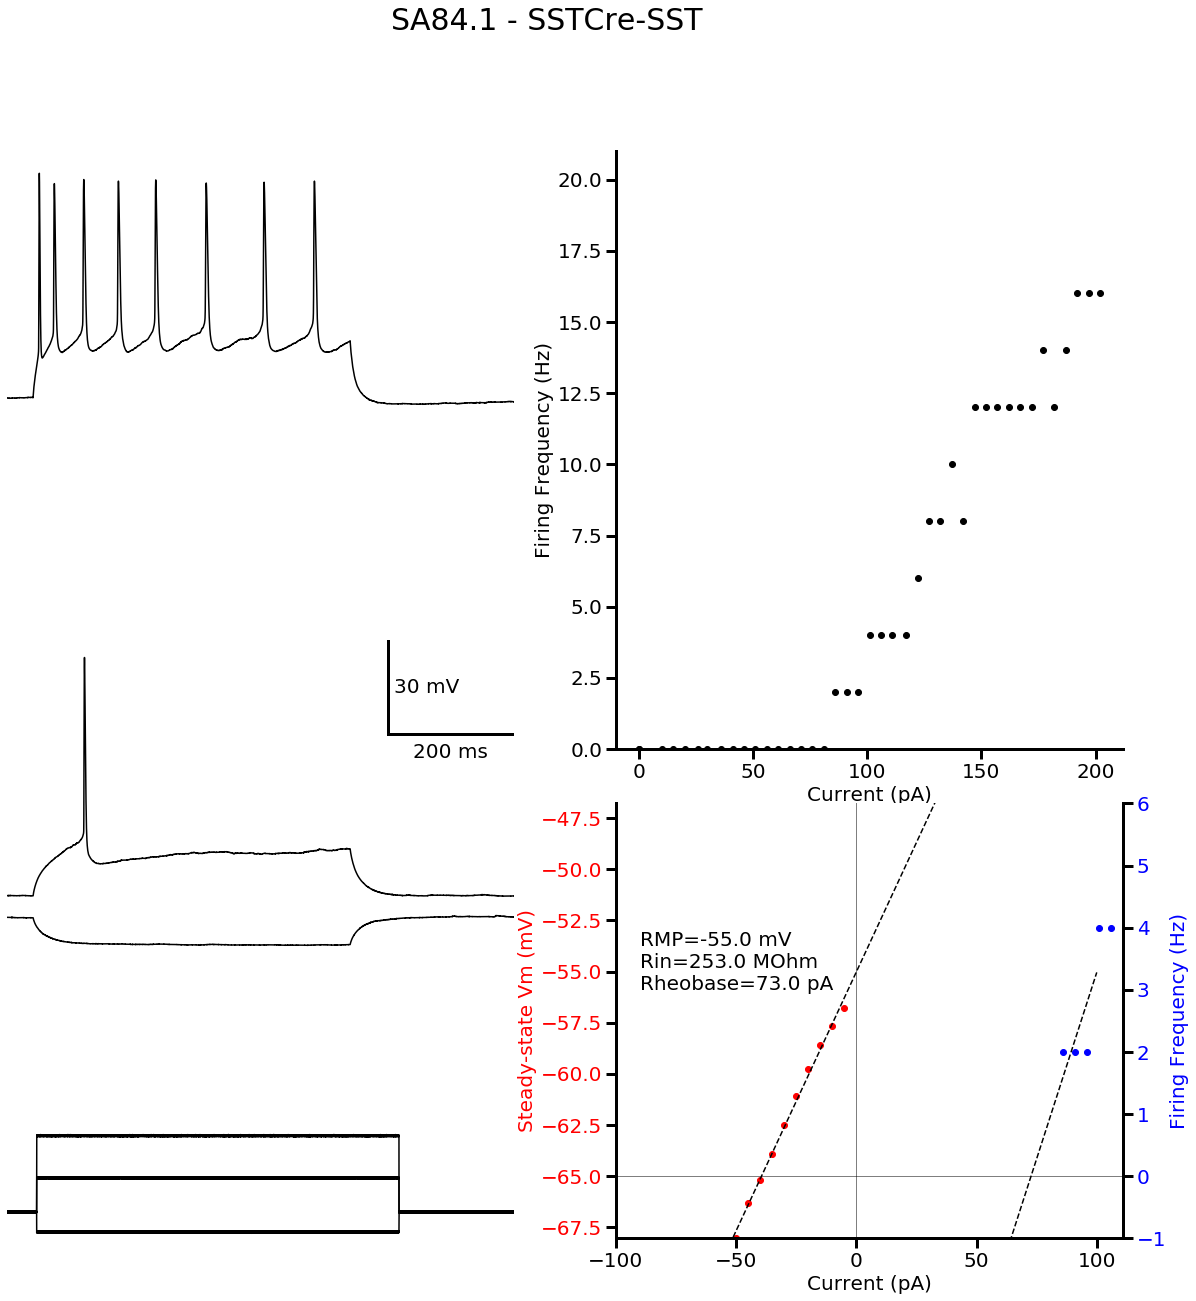

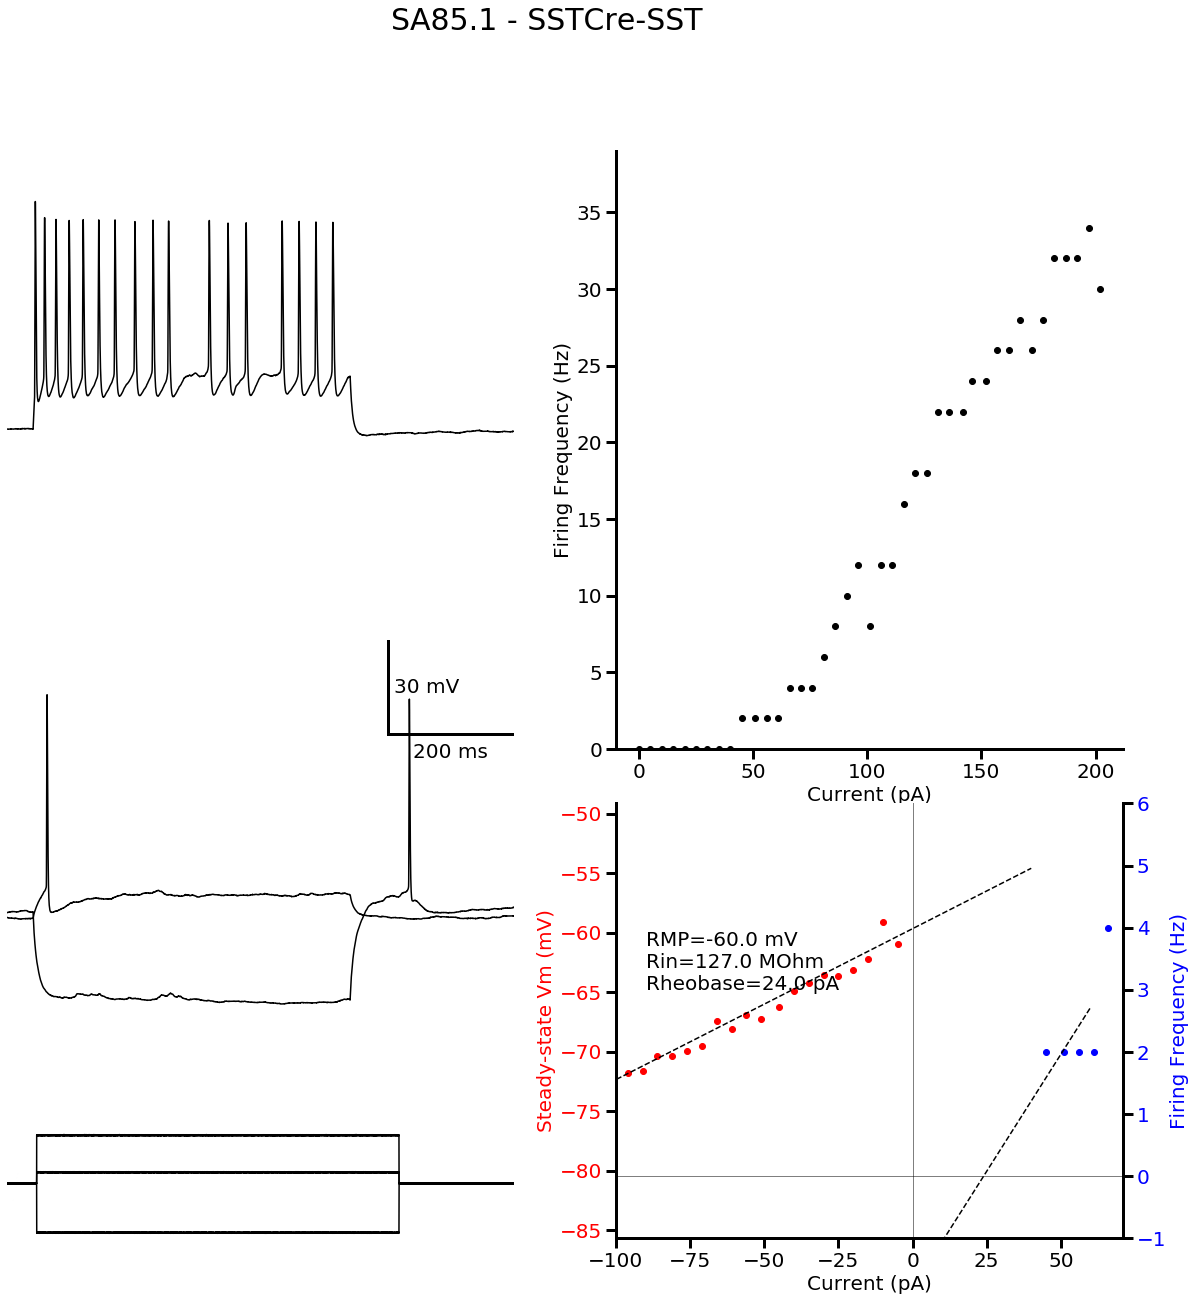

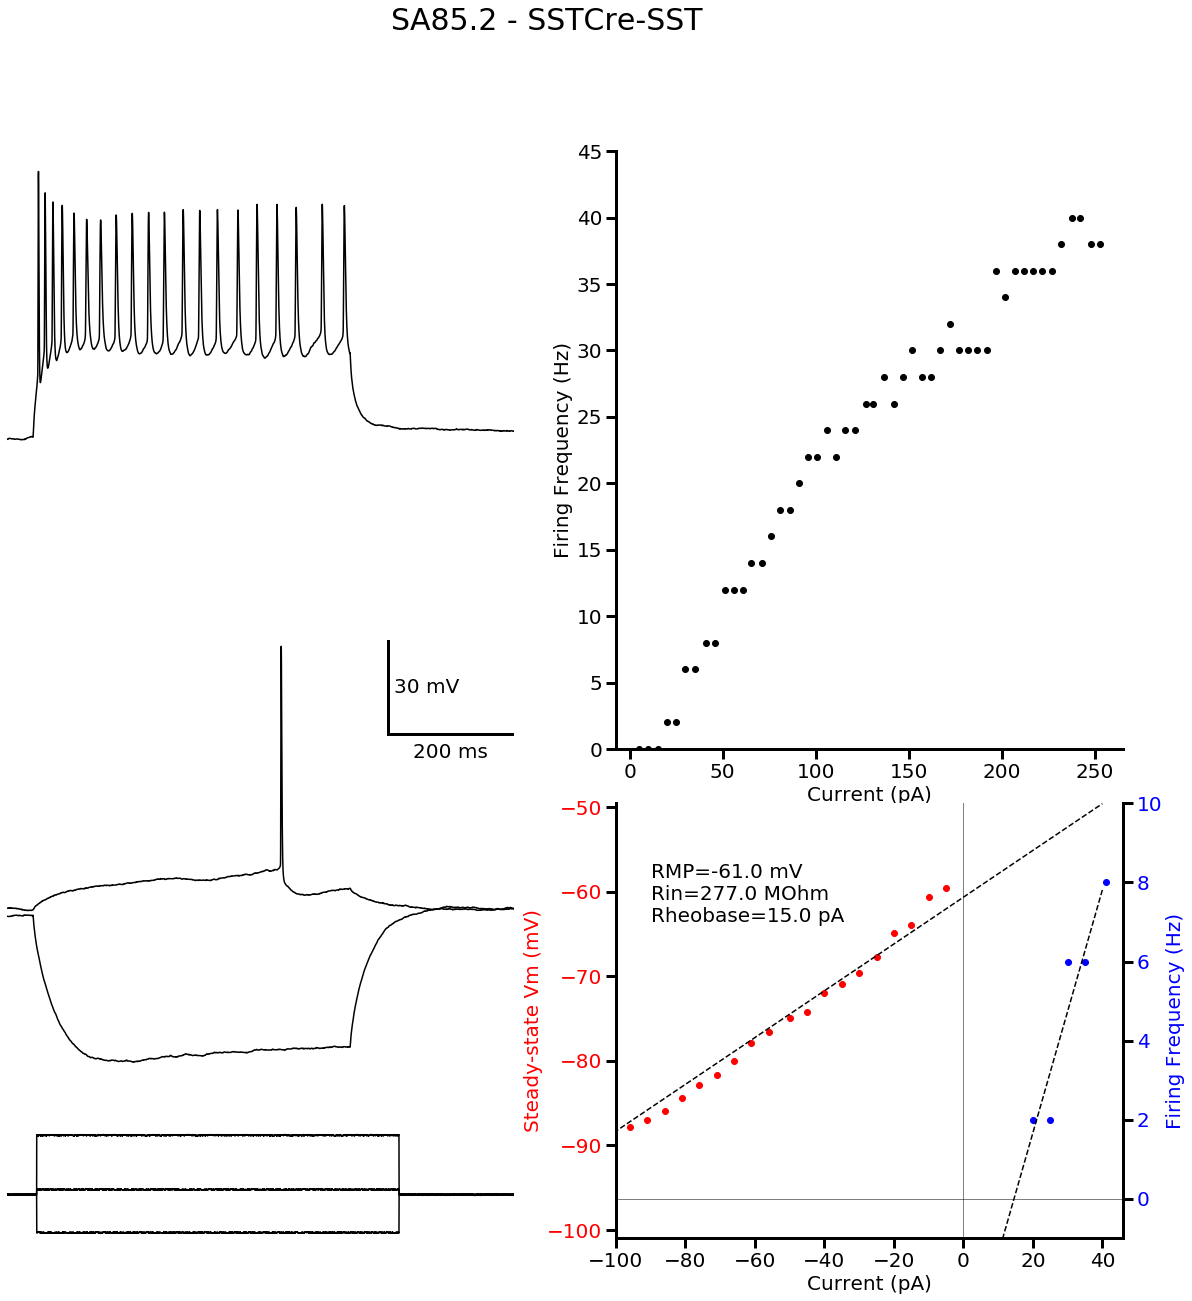

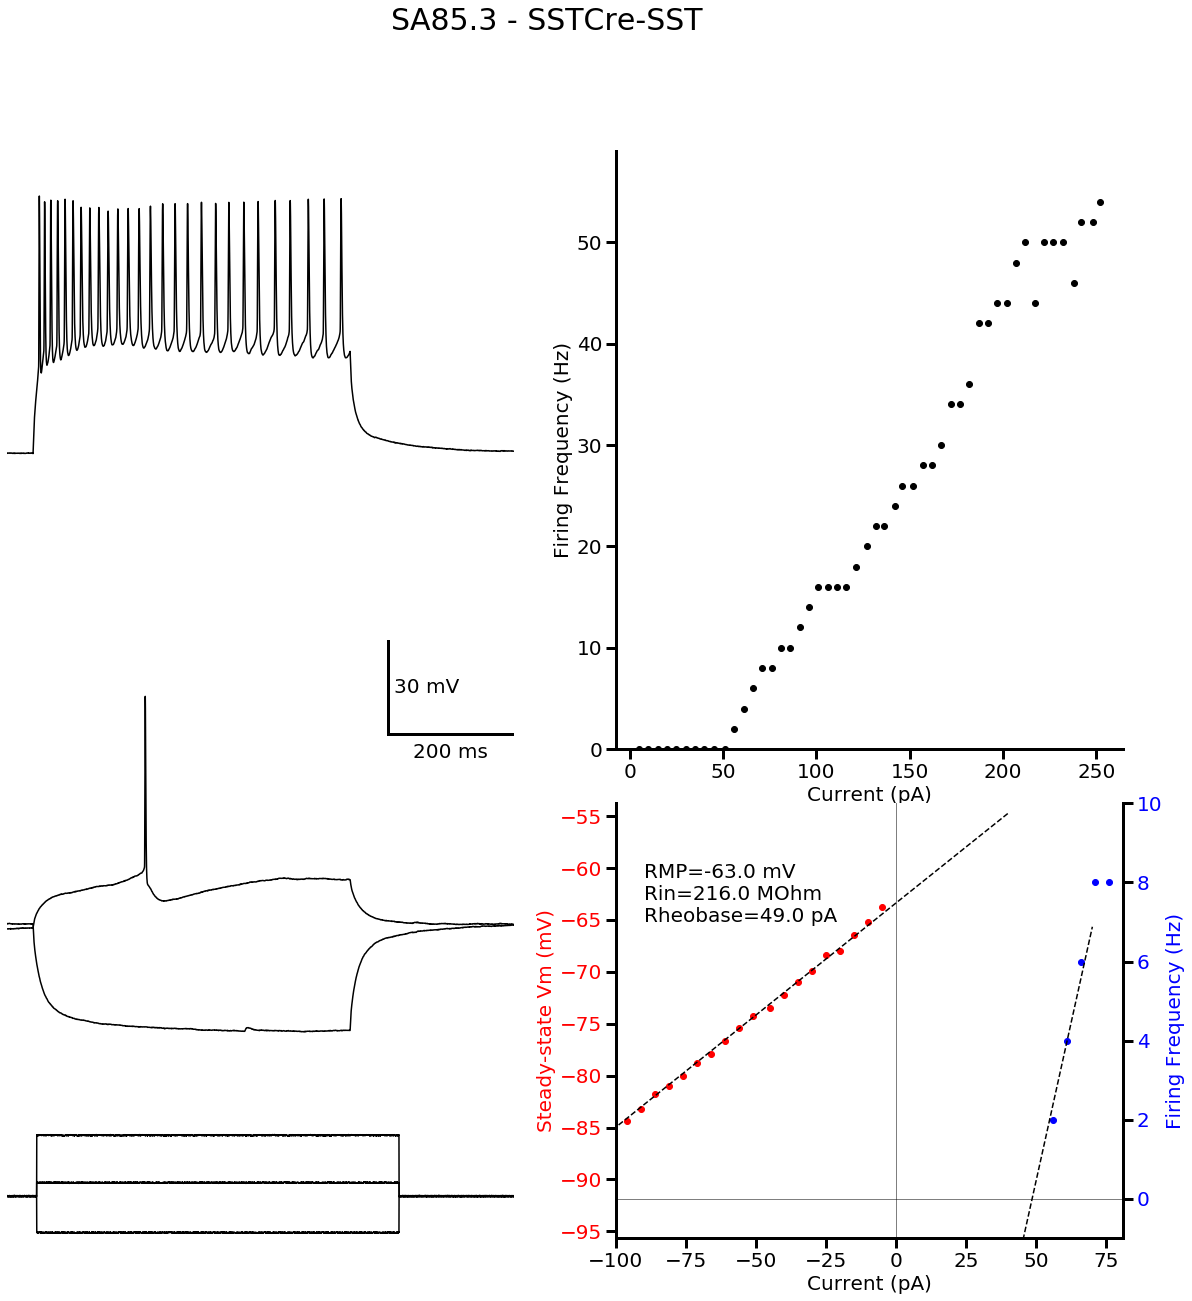

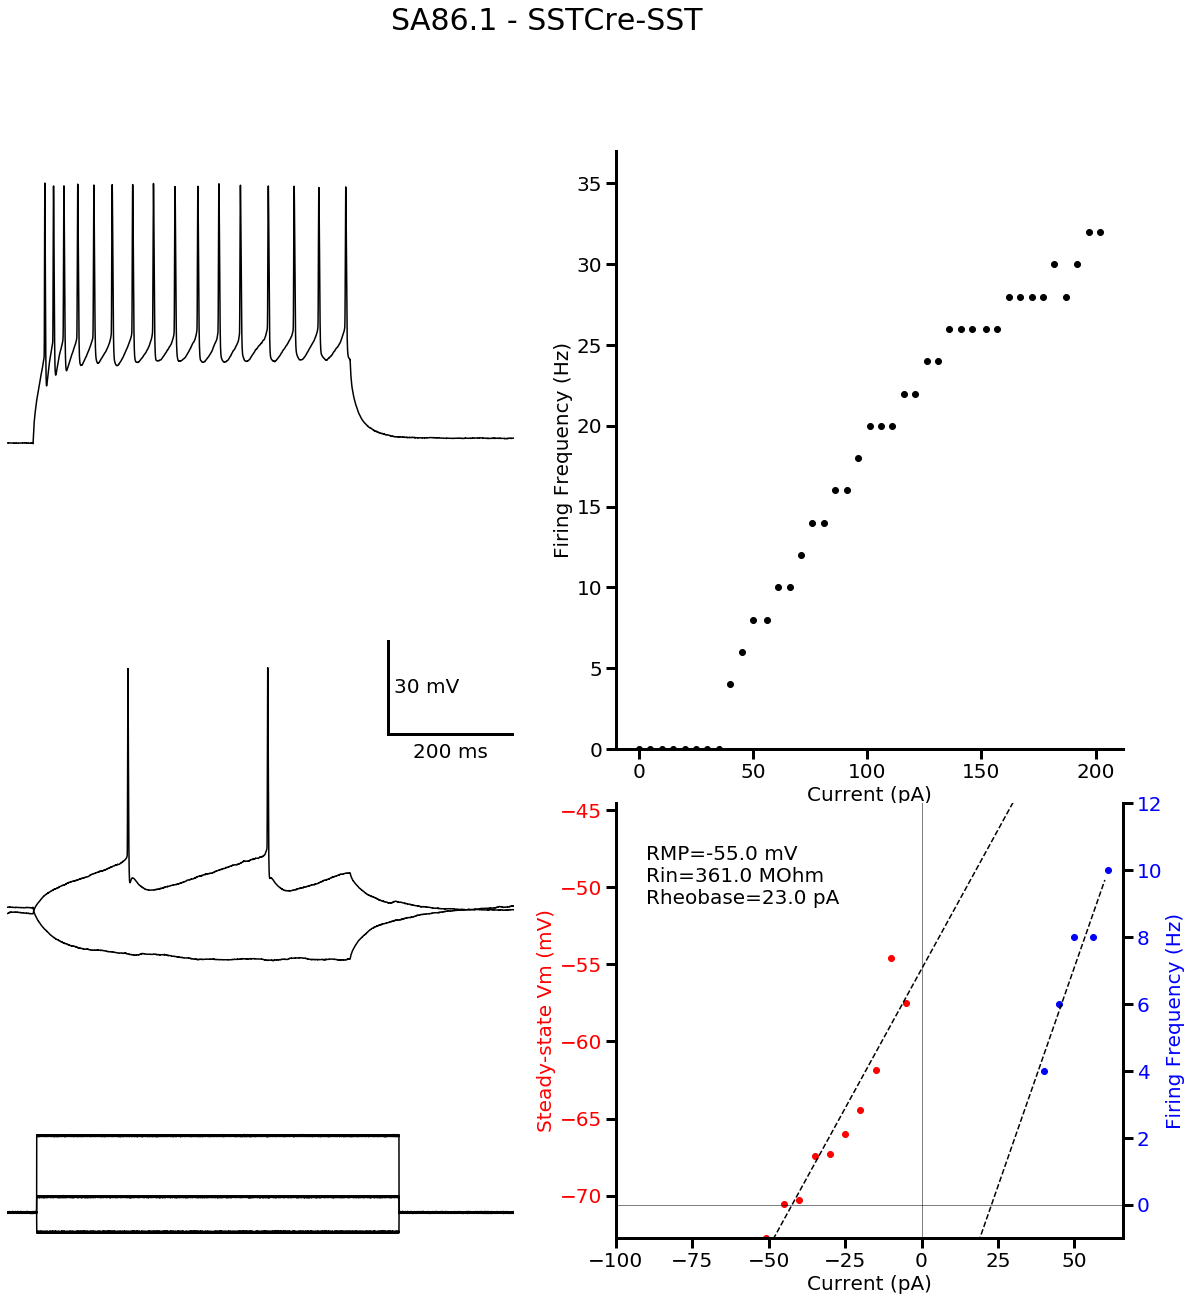

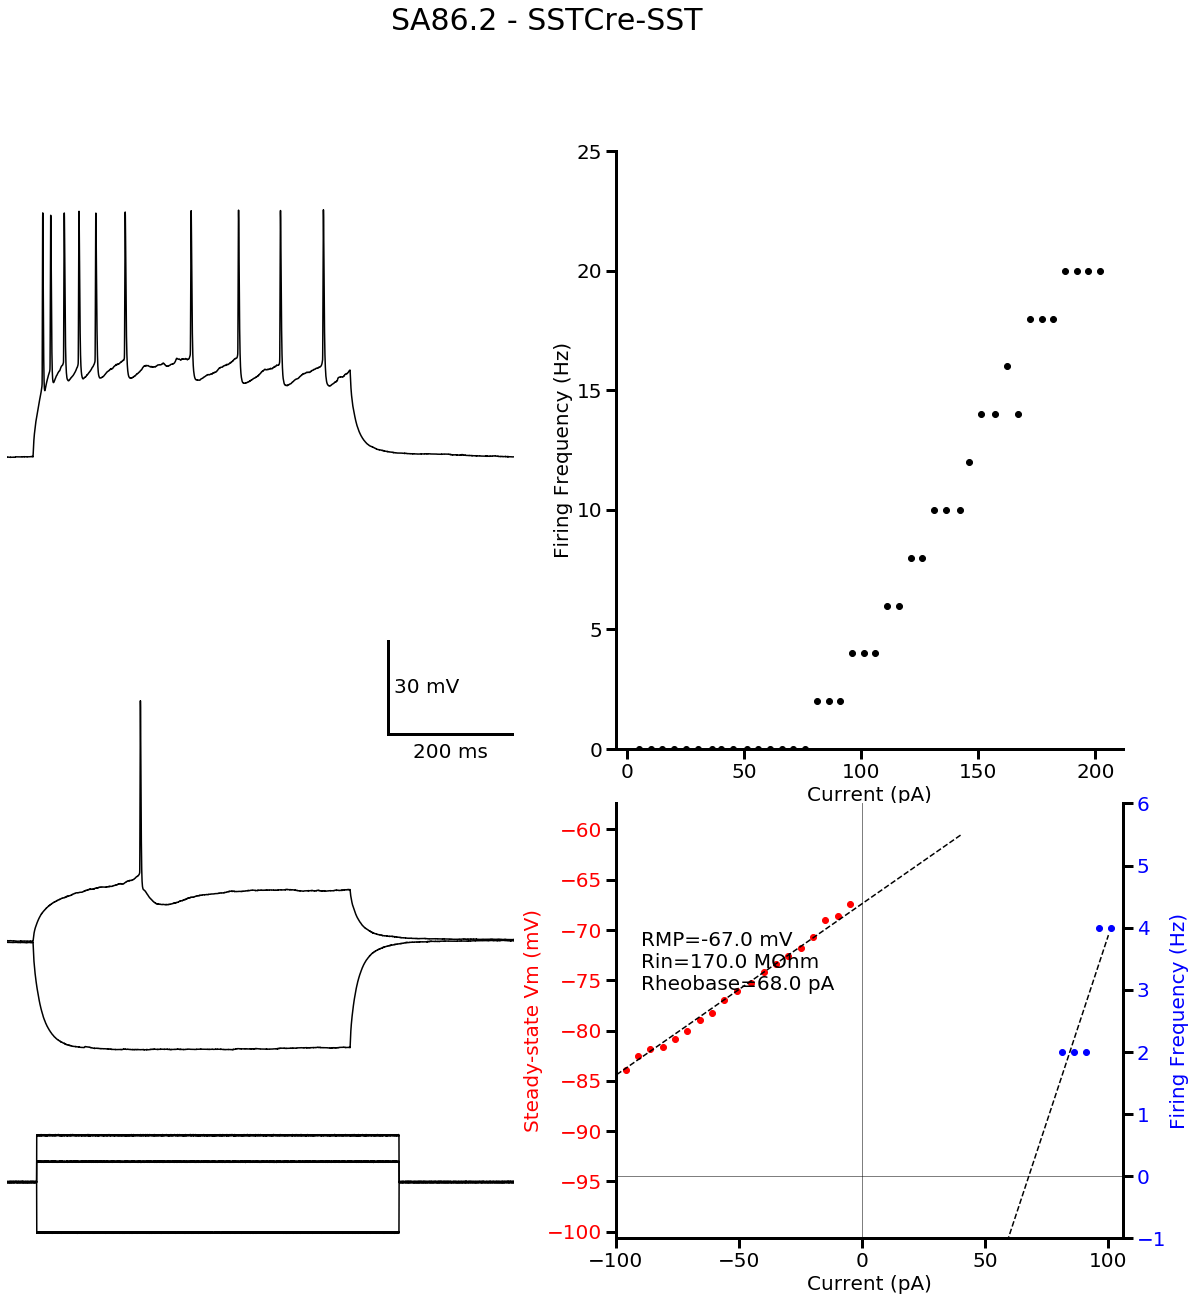

In [7]:
data = pd.read_csv("D:\InVitro_V1vsS1BF\LSPSData\TheBible.csv")
data = data[data.Experiment=='IntrinsicProfile']

#Initialize results dataframe
resultsColumns = ['Cell_ID','CellTarget','CellType','RMP','Rin','Tau','Rheobase','AP_Threshold','AP_Height','AP_HalfWidth','AP_AHP','MaxFiringFrequency', 'AdaptationIndex', 'VoltageSag']
results = pd.DataFrame(columns=resultsColumns)

for cellID in np.unique(data.CellID):
    print(cellID)
    neuron=data[data.CellID==cellID]
    
    results.loc[len(results), :] = Analyse_Neuron(neuron)
results


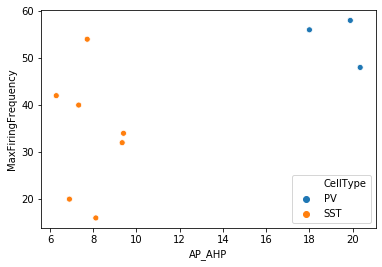

In [324]:
import seaborn as sns

sns.scatterplot(x='AP_AHP', y='MaxFiringFrequency', hue='CellType',data=results)